<a href="https://colab.research.google.com/github/danielhazann/RL_project/blob/main/LunarLanderContinuous/Copy_of_FinalLunarLanderA2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]
import gym

In [ ]:
import numpy as np 

import torch
import torch.nn as nn
import torch.nn.functional as F

class Actor(nn.Module):

    def __init__(self, s_size, a_size, seed):
        super(Actor, self).__init__()

        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(s_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, a_size)
        # self.bn1 = nn.BatchNorm1d(64)
        # self.bn2 = nn.BatchNorm1d(32)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class Critic(nn.Module):

    def __init__(self, s_size, a_size, seed):
        super(Critic, self).__init__()

        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(s_size, 512)
        self.fc2 = nn.Linear(512+a_size, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, state, action):
        x = F.leaky_relu(self.fc1(state))
        x = torch.cat((x, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)
BATCH_SIZE= 64
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 0.001        # learning rate of the actor 
LR_CRITIC = 0.003        # learning rate of the critic
WEIGHT_DECAY = 0.0001 

class Agent():

    def __init__(self, s_size, a_size, seed):

        self.s_size = s_size
        self.a_size = a_size
        self.seed = seed

        self.actor_local = Actor(s_size, a_size, seed).to(device)
        self.actor_target = Actor(s_size, a_size, seed).to(device)
        self.actor_optim = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        self.critic_local = Critic(s_size, a_size, seed).to(device)
        self.critic_target = Critic(s_size, a_size, seed).to(device)
        self.critic_optim = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC)

        self.noise = OUNoise(a_size, seed)
        self.memory = ReplayBuffer(a_size, BUFFER_SIZE, BATCH_SIZE, seed)

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=False):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []

        for e in experiences:

            if len(states) == 0:
                states = np.append(states, e.state)
                actions = np.append(actions, e.action)
                rewards = np.append(rewards, e.reward)
                next_states = np.append(next_states, e.next_state)
                dones = np.append(dones, e.done)
            else:
                states = np.vstack((states, e.state))
                actions = np.vstack((actions, e.action))
                rewards = np.vstack((rewards, e.reward))
                next_states = np.vstack((next_states, e.next_state))
                dones = np.vstack((dones, e.done))

        # print(states)
        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).float().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)			
        dones = torch.from_numpy(dones).float().to(device)
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state


class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):

        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        return random.sample(self.memory, k=self.batch_size)

    def __len__(self):
        return len(self.memory)


class Experience:

    def __init__(self, state, action, reward, next_state, done):

        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.done = done

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
env = gym.make('LunarLanderContinuous-v2')
env.seed(32)
agent = Agent(s_size=8, a_size=2, seed=32)

In [ ]:
def ddpg(n_episodes=2000, max_t=500):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")

        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque))) 
            

            if np.mean(scores_deque)>=200.0:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
                break
            
            scores_deque = deque(maxlen=100)

    return scores

scores = ddpg()

Episode 100	Average Score: -454.51
Episode 200	Average Score: -92.92
Episode 300	Average Score: -28.90
Episode 400	Average Score: 54.87
Episode 500	Average Score: 90.20
Episode 600	Average Score: 99.68
Episode 700	Average Score: 124.82
Episode 800	Average Score: 144.33
Episode 900	Average Score: 134.89
Episode 1000	Average Score: 168.03
Episode 1100	Average Score: 218.66

Environment solved in 1000 episodes!	Average Score: 218.66


In [ ]:
import matplotlib.pyplot as plt

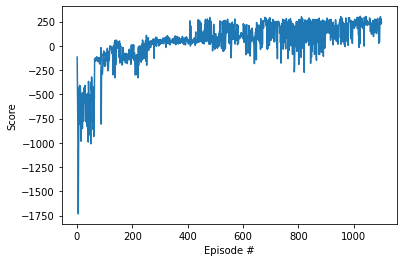

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
np.savetxt("LunarLanderScores_A2C.csv", scores, delimiter=",")